An analysis may require the ability to generate correlated random samples. For example, 
imagine we have monthly returns for three financial indicators over a 20 year period. We 
are interested in modeling these returns using parametric distributions for some downstream 
analysis, perhaps to estimate tail behavior over a large number of samples. In this post, 
I'll demonstrate that assuming independence of truly correlated random variables falls short, 
and how to correctly model the correlation for sample generation. The financial indicator
data is available [here](https://gist.githubusercontent.com/jtrive84/9955433e344ec773e5766657f961fde5/raw/b2e2c99db1e05aeb69186550b9c78cc9412df911/sample_returns.csv).



In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

indicator_url = "https://gist.githubusercontent.com/jtrive84/9955433e344ec773e5766657f961fde5/raw/b2e2c99db1e05aeb69186550b9c78cc9412df911/sample_returns.csv"

df = pd.read_csv(indicator_url)

df.head()


,date,us_credit,us_market,global_market
0,1/31/2001,0.035525,0.0301,0.022123
1,2/28/2001,-0.001583,-0.0950,-0.091336
2,3/31/2001,0.002638,-0.0675,-0.075002
3,4/30/2001,0.010607,0.0738,0.075063
4,5/31/2001,0.010448,0.0035,-0.010473


The table contains monthly returns for us_credit, us_market and global_market from 2001-01-31
up to 2023-06-30, but our approach can be extended to any number of financial indicators. Our 
goal is to find an appropriate parametric distribution for each indicator to use for sample 
generation. We start by plotting histograms of each indicator to get an idea of the distributional 
form (symmetric, skewed, etc.). This will dictate which distribution we use to find the best fitting parameters via maximum likelihood. Since there are positive and negative values for each indicator, using a normal distribution is probably a safe bet. If values of the indicators were strictly positive, we would use a distribution with support on $(0, \infty)$ such as gamma, lognormal or weibull.


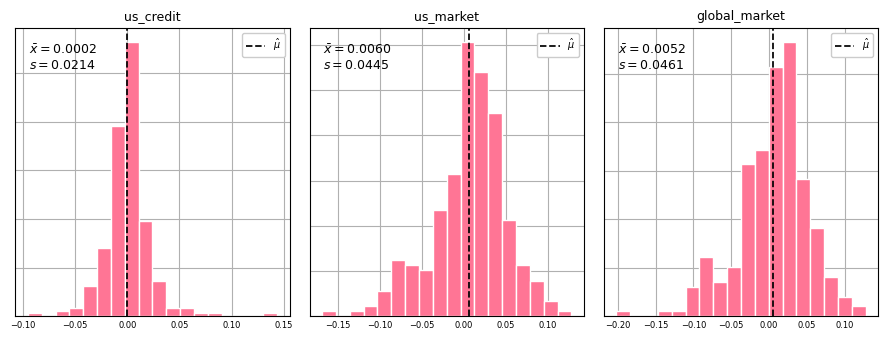

In [2]:
# | fig-cap: Distribution of returns for each indicator
# | fig-alt: Histograms for us_credit, us_market and global_market.

# Plot histogram for each indicator.
df = df.drop("date", axis=1)

indicators = df.columns

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3.5), tight_layout=True) 

for ii, ind_name in enumerate(indicators):
    
    ind_mean, ind_std = df[ind_name].mean(), df[ind_name].std()
    label0 = r"$\bar x = $" + f"{ind_mean:,.4f}"
    label1 = r"$s = $" + f"{ind_std:,.4f}"
    ax[ii].set_title(ind_name, color="#000000", loc="center", fontsize=9)
    ax[ii].hist(
        df[ind_name].values, 18, density=True, alpha=1, color="#ff7595", 
        edgecolor="#FFFFFF", linewidth=1.0
        )
    
    ax[ii].axvline(ind_mean, color="#000000", linewidth=1.25, linestyle="--", label=r"$\hat \mu$")
    ax[ii].set_yticklabels([])
    ax[ii].set_xlabel("")
    ax[ii].set_ylabel("")
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="x", which="minor", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="minor", direction='in', labelsize=6)
    ax[ii].xaxis.set_ticks_position("none")
    ax[ii].yaxis.set_ticks_position("none")
    ax[ii].grid(True)   
    ax[ii].set_axisbelow(True) 
    
    ax[ii].annotate(
        label0, xy=(.05, .90), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=9, rotation=0, weight="normal", color="#000000"
        ) 
    ax[ii].annotate(
        label1, xy=(.05, .85), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=9, rotation=0, weight="normal", color="#000000"
        ) 
    ax[ii].legend(loc="upper right", fancybox=True, framealpha=1, fontsize="x-small")
    
plt.show();



The distribution of each indicator appears relatively normal. Given that the parametric form has been identified, we can use Scipy to determine the optimal parameters to fit three separate normal distributions (one per indicator) via maximum likelihood. 


In [3]:

from scipy.stats import norm

# Get normal parameter estimates (mean & standard deviation) via maximum likelihood.
mu0, std0 = norm.fit(df["us_credit"], method="MLE")
mu1, std1 = norm.fit(df["us_market"], method="MLE")
mu2, std2 = norm.fit(df["global_market"], method="MLE")

dparams = {
    "us_credit": {"mean": mu0, "std": std0},
    "us_market": {"mean": mu1, "std": std1},
    "global_market": {"mean": mu2, "std": std2},
    }

print(f"\n- us_credit    : mean={mu0:,.5f} std=={std0:,.5f}")
print(f"- us_market    : mean={mu1:,.5f} std=={std1:,.5f}")
print(f"- global_market: mean={mu2:,.5f} std=={std2:,.5f}\n")



- us_credit    : mean=0.00015 std==0.02138
- us_market    : mean=0.00595 std==0.04442
- global_market: mean=0.00517 std==0.04605




The parameter estimates match very closely with the empirical mean and standard deviation
overlaid on each histogram. This is because the MLE estimates for the normal distribution are equal to the sample mean and the unadjusted sample variance. Next we overlay the best fitting parametric distribution with each indicator histogram in order to assess the quality of fit. 


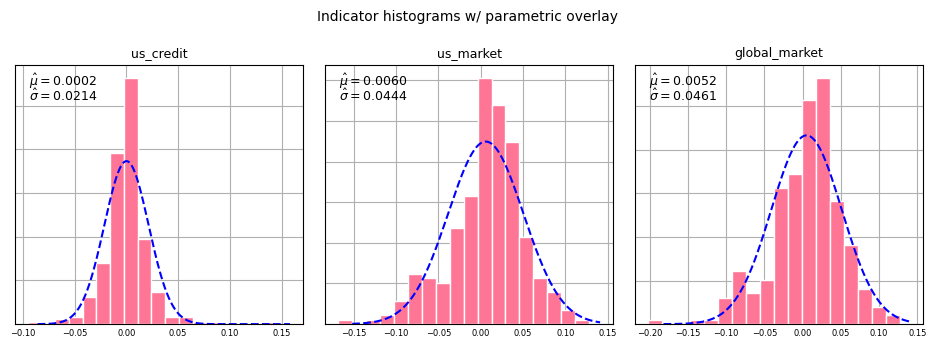

In [4]:
# | fig-cap: Indicator histograms with parametric overlay
# | fig-alt: Histograms for us_credit, us_market and global_market with normal density overlay

# Plot histogram for each indicator along with parameterized normal distribution.
hist_color = "#ff7595"
dist_color = "#0000FF"

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9.5, 3.5), tight_layout=True) 

for ii, ind_name in enumerate(indicators):

    vals = df[ind_name]
    mle_mean, mle_std = dparams[ind_name]["mean"], dparams[ind_name]["std"]

    # Get PDF values associated with distribution.
    ndist = norm(mle_mean, mle_std)
    xvals = np.linspace(vals.min() * .90, vals.max() * 1.10, 1000)
    yvals = ndist.pdf(xvals)

    label0 = r"$\hat \mu = $" + f"{mle_mean:,.4f}"
    label1 = r"$\hat \sigma = $" + f"{mle_std:,.4f}"
    
    ax[ii].set_title(ind_name, color="#000000", loc="center", fontsize=9)
    ax[ii].hist(
        df[ind_name].values, 18, density=True, alpha=1, color=hist_color, 
        edgecolor="#FFFFFF", linewidth=1.0
        )

    # Plot normal distribution.
    ax[ii].plot(xvals, yvals, linewidth=1.5, color=dist_color, linestyle="--")
    ax[ii].set_yticklabels([])
    ax[ii].set_xlabel("")
    ax[ii].set_ylabel("")
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="x", which="minor", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="minor", direction='in', labelsize=6)
    ax[ii].xaxis.set_ticks_position("none")
    ax[ii].yaxis.set_ticks_position("none")
    ax[ii].grid(True)   
    ax[ii].set_axisbelow(True) 
    
    ax[ii].annotate(
        label0, xy=(.05, .90), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=9, rotation=0, weight="normal", color="#000000"
        ) 
    ax[ii].annotate(
        label1, xy=(.05, .85), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=9, rotation=0, weight="normal", color="#000000"
        ) 
    #ax[ii].legend(loc="upper right", fancybox=True, framealpha=1, fontsize="x-small")
plt.suptitle("Indicator histograms w/ parametric overlay", fontsize=10)
plt.show();




The distributions in each case enclose the original histograms pretty well, with decent tail coverage in each instance. To demonstrate the approach, we next generate independent random samples from each indicator. 


In [5]:

# Specify number of samples to generate.
nbr_sims = 500

# Copying dparams from previous cell.
dparams = {
    "us_credit": {"mean": mu0, "std": std0},
    "us_market": {"mean": mu1, "std": std1},
    "global_market": {"mean": mu2, "std": std2},
    }

# us_credit.
mean0, std0 = dparams["us_credit"]["mean"], dparams["us_credit"]["std"]
rv0 = norm(mean0, std0)

# us_market.
mean1, std1 = dparams["us_market"]["mean"], dparams["us_market"]["std"]
rv1 = norm(mean1, std1)

# global_market.
mean2, std2 = dparams["global_market"]["mean"], dparams["global_market"]["std"]
rv2 = norm(mean2, std2)

# Create DataFrame to hold simulated indicators. 
dfsims1 = pd.DataFrame(
    np.vstack([rv0.rvs(nbr_sims), rv1.rvs(nbr_sims), rv2.rvs(nbr_sims)]).T,
    columns=indicators
    )

dfsims1.describe()


,us_credit,us_market,global_market
count,500.000000,500.000000,500.000000
mean,0.000558,0.012024,0.006257
std,0.022043,0.042455,0.045772
min,-0.072494,-0.115241,-0.148560
25%,-0.014534,-0.017264,-0.024564
50%,-0.000501,0.014443,0.007020
75%,0.014217,0.042519,0.038046
max,0.069504,0.149524,0.132896



Here we assume the value that an indicator takes on is independent of all other indicators. 
This is almost surely not the case. Let's check how correlated the 3 selected indicators are
within the original sample:

In [6]:

df.corr()


,us_credit,us_market,global_market
us_credit,1.000000,-0.099877,-0.037652
us_market,-0.099877,1.000000,0.955514
global_market,-0.037652,0.955514,1.000000




Do the independent samples exhibit the same correlation?

In [7]:

dfsims1.corr()


,us_credit,us_market,global_market
us_credit,1.000000,-0.072533,-0.066023
us_market,-0.072533,1.000000,-0.044359
global_market,-0.066023,-0.044359,1.000000


Not surprisingly, us_market and global_market are over 95% correlated in the original data. 
This is not exhibited within the set of non-correlated samples. With such high correlation,
it is not reasonable to assume independence across indicators. We need instead to find a way to 
generate correlated random samples. This can be accomplished using Numpy's multivariate normal distribution. 

As a brief aside, the significance of a correlation between two random variables depends on the sample size. 
To test if the correlation between two variables demonstrates a linear relationship at the 5% 
significance level, we compute:

$$
|\rho| \gt 2 / \sqrt{n},
$$

In our case, there are 270 samples, therefore $n = \sqrt{270} \approx 16.4$. Thus,
in order for the correlation between two indicators to be significant at the 5% 
level, it needs to be greater than $2 / 16.4 \approx .12$, which is clearly the case for 
global_market-us_market.


In [8]:

# Generate correlated random samples.
# Specify number of simulations to generate.
nbr_sims = 500

# Create vector of means.
means = [mean0, mean1, mean2]

# Bind reference to covariance matrix.
V = df.cov().values

dfsims2 = pd.DataFrame(
    np.random.multivariate_normal(means, V, nbr_sims),
    columns=indicators
    )

dfsims2.describe()


,us_credit,us_market,global_market
count,500.000000,500.000000,500.000000
mean,0.000547,0.005966,0.005387
std,0.021886,0.042421,0.044833
min,-0.062250,-0.097373,-0.137454
25%,-0.013780,-0.024495,-0.027463
50%,0.000788,0.007268,0.006098
75%,0.015203,0.033833,0.035412
max,0.067324,0.136830,0.148773



The min and max values for each indicator seem to align with what was observed in the 
original data. Let's verify that the samples in `dfsims2` are correlated.

In [9]:

dfsims2.corr()


,us_credit,us_market,global_market
us_credit,1.000000,-0.084854,-0.038219
us_market,-0.084854,1.000000,0.944791
global_market,-0.038219,0.944791,1.000000


This matches closely with the original correlation profile.
Let's visualize the correlation in the generated random samples by comparing indicator samples from the independent simulated dataset vs. the dependent simulated dataset.





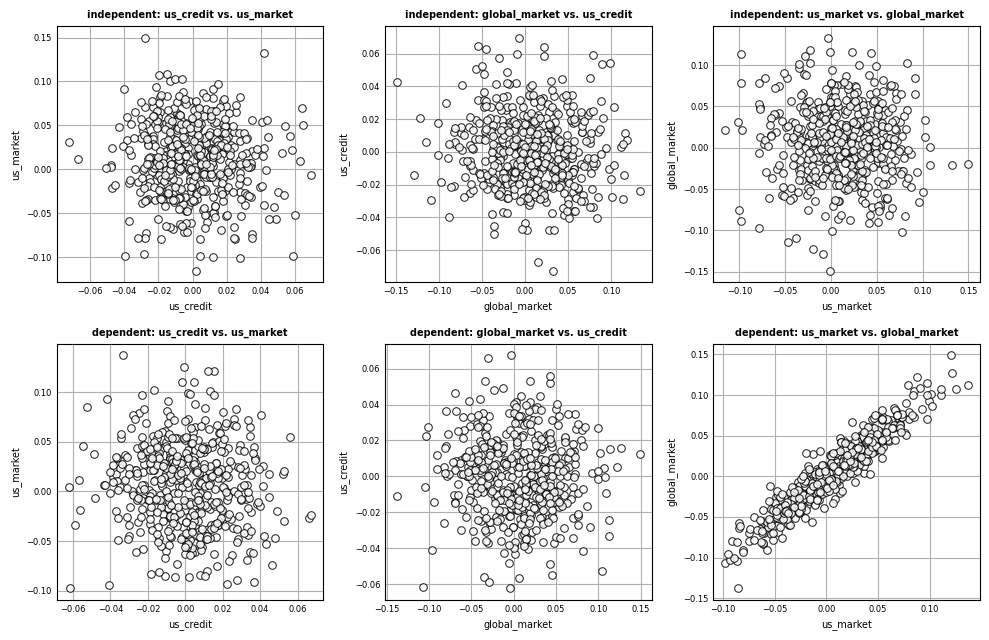

In [10]:
# | fig-cap: Scatterplots by indicator pair for correlated and uncorrelated samples. 
# | fig-alt: Scatterplots by indicator pair for correlated and uncorrelated samples. 

# Generate pair-wise scatter plots for each indicator for independent and dependent draws. 

dindices = {
    (0, 0): {"data": "independent", "x": "us_credit", "y": "us_market"},
    (0, 1): {"data": "independent", "x": "global_market", "y": "us_credit"},
    (0, 2): {"data": "independent", "x": "us_market", "y": "global_market"},
    (1, 0): {"data": "dependent", "x": "us_credit", "y": "us_market"},
    (1, 1): {"data": "dependent", "x": "global_market", "y": "us_credit"},
    (1, 2): {"data": "dependent", "x": "us_market", "y": "global_market"},
    }


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6.5), tight_layout=True) 

for kk, vv in dindices.items():
    
    ii, jj = kk
    data_desc, x_desc, y_desc = vv["data"], vv["x"], vv["y"]

    if data_desc == "independent":
        xx = dfsims1[x_desc].values
        yy = dfsims1[y_desc].values
    else:
        xx = dfsims2[x_desc].values
        yy = dfsims2[y_desc].values
        
    titlestr = f"{data_desc}: {x_desc} vs. {y_desc}"
    ax[ii, jj].set_title(titlestr, color="#000000", loc="center", weight="bold", fontsize=7)
    ax[ii, jj].scatter(
        xx, yy, s=30, c="#FFFFFF", alpha=.85, edgecolor="#000000", linewidth=.75)

    # ax[ii].set_yticklabels([])
    ax[ii, jj].set_xlabel(x_desc, fontsize=7)
    ax[ii, jj].set_ylabel(y_desc, fontsize=7)
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="x", which="minor", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="minor", direction='in', labelsize=6)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 

plt.show();


In the case of global_market-us_market (bottom right), the dependent plot captures the correlation inherent in the original data. 
